# (11468) Shantanunaidu orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '11468'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, de_kernel_path, t_min_tdb=None, t_max_tdb=None, verbose=True)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 24 observations 
	 24 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 623 observations. Debiased 966 observations. No biasing information for 24 observations.
Applied default weight of 1 arcsec to 102 CCD observations
Deweighted 407 observations as part of deweighting scheme.
Found 230 observations from Gaia DR3.
	 Added 30 of those observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.458			 0.521			 872.636			 0.266
2			 0.458			 0.520			 871.263			 0.266
3			 0.458			 0.520			 871.263			 0.266
Converged without rejecting outliers. Starting outlier rejection now.
4			 0.414			 0.488			 761.721			 0.233
5			 0.414			 0.488			 761.757			 0.233
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 5 (of 5):
RMS unweighted: 0.41353717866185474
RMS weighted: 0.4876819621156552
chi-squared: 761.7566214489439
reduced chi-squared: 0.23323840215828043
square root of reduced chi-squared: 0.4829476184414625
t: MJD 57500.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			1.66697868063e-01		6.73767951889e-09 		1.66697862059e-01		6.71816397448e-09 		-6.00424385211e-09		-0.891
q			2.56503023084e+00		2.00660624764e-08 		2.56503024872e+00		1.99630713119e-08 		+1.78850223520e-08		+0.891
tp			5.75113652724e+04		3.28498193378e-05 		5.75113652730e+04		3.22847878265e-05 		+5.27950760443e-07		+0.016
om			2.06376077176e+02		2.70610101692e-05 		2.06376092103e+02		2.70491073243e-05 		+1.49271507439e-05		+0.552
w			1.54026406216e+02		2.84582407556e-05 		1.54026391291e+02		2.83512510657e-05 		-1.49251918344e-05		-0.524
i			7.88793990680e-01		5.14004162240e-07 		7.88794215425e-01		5.06527570212

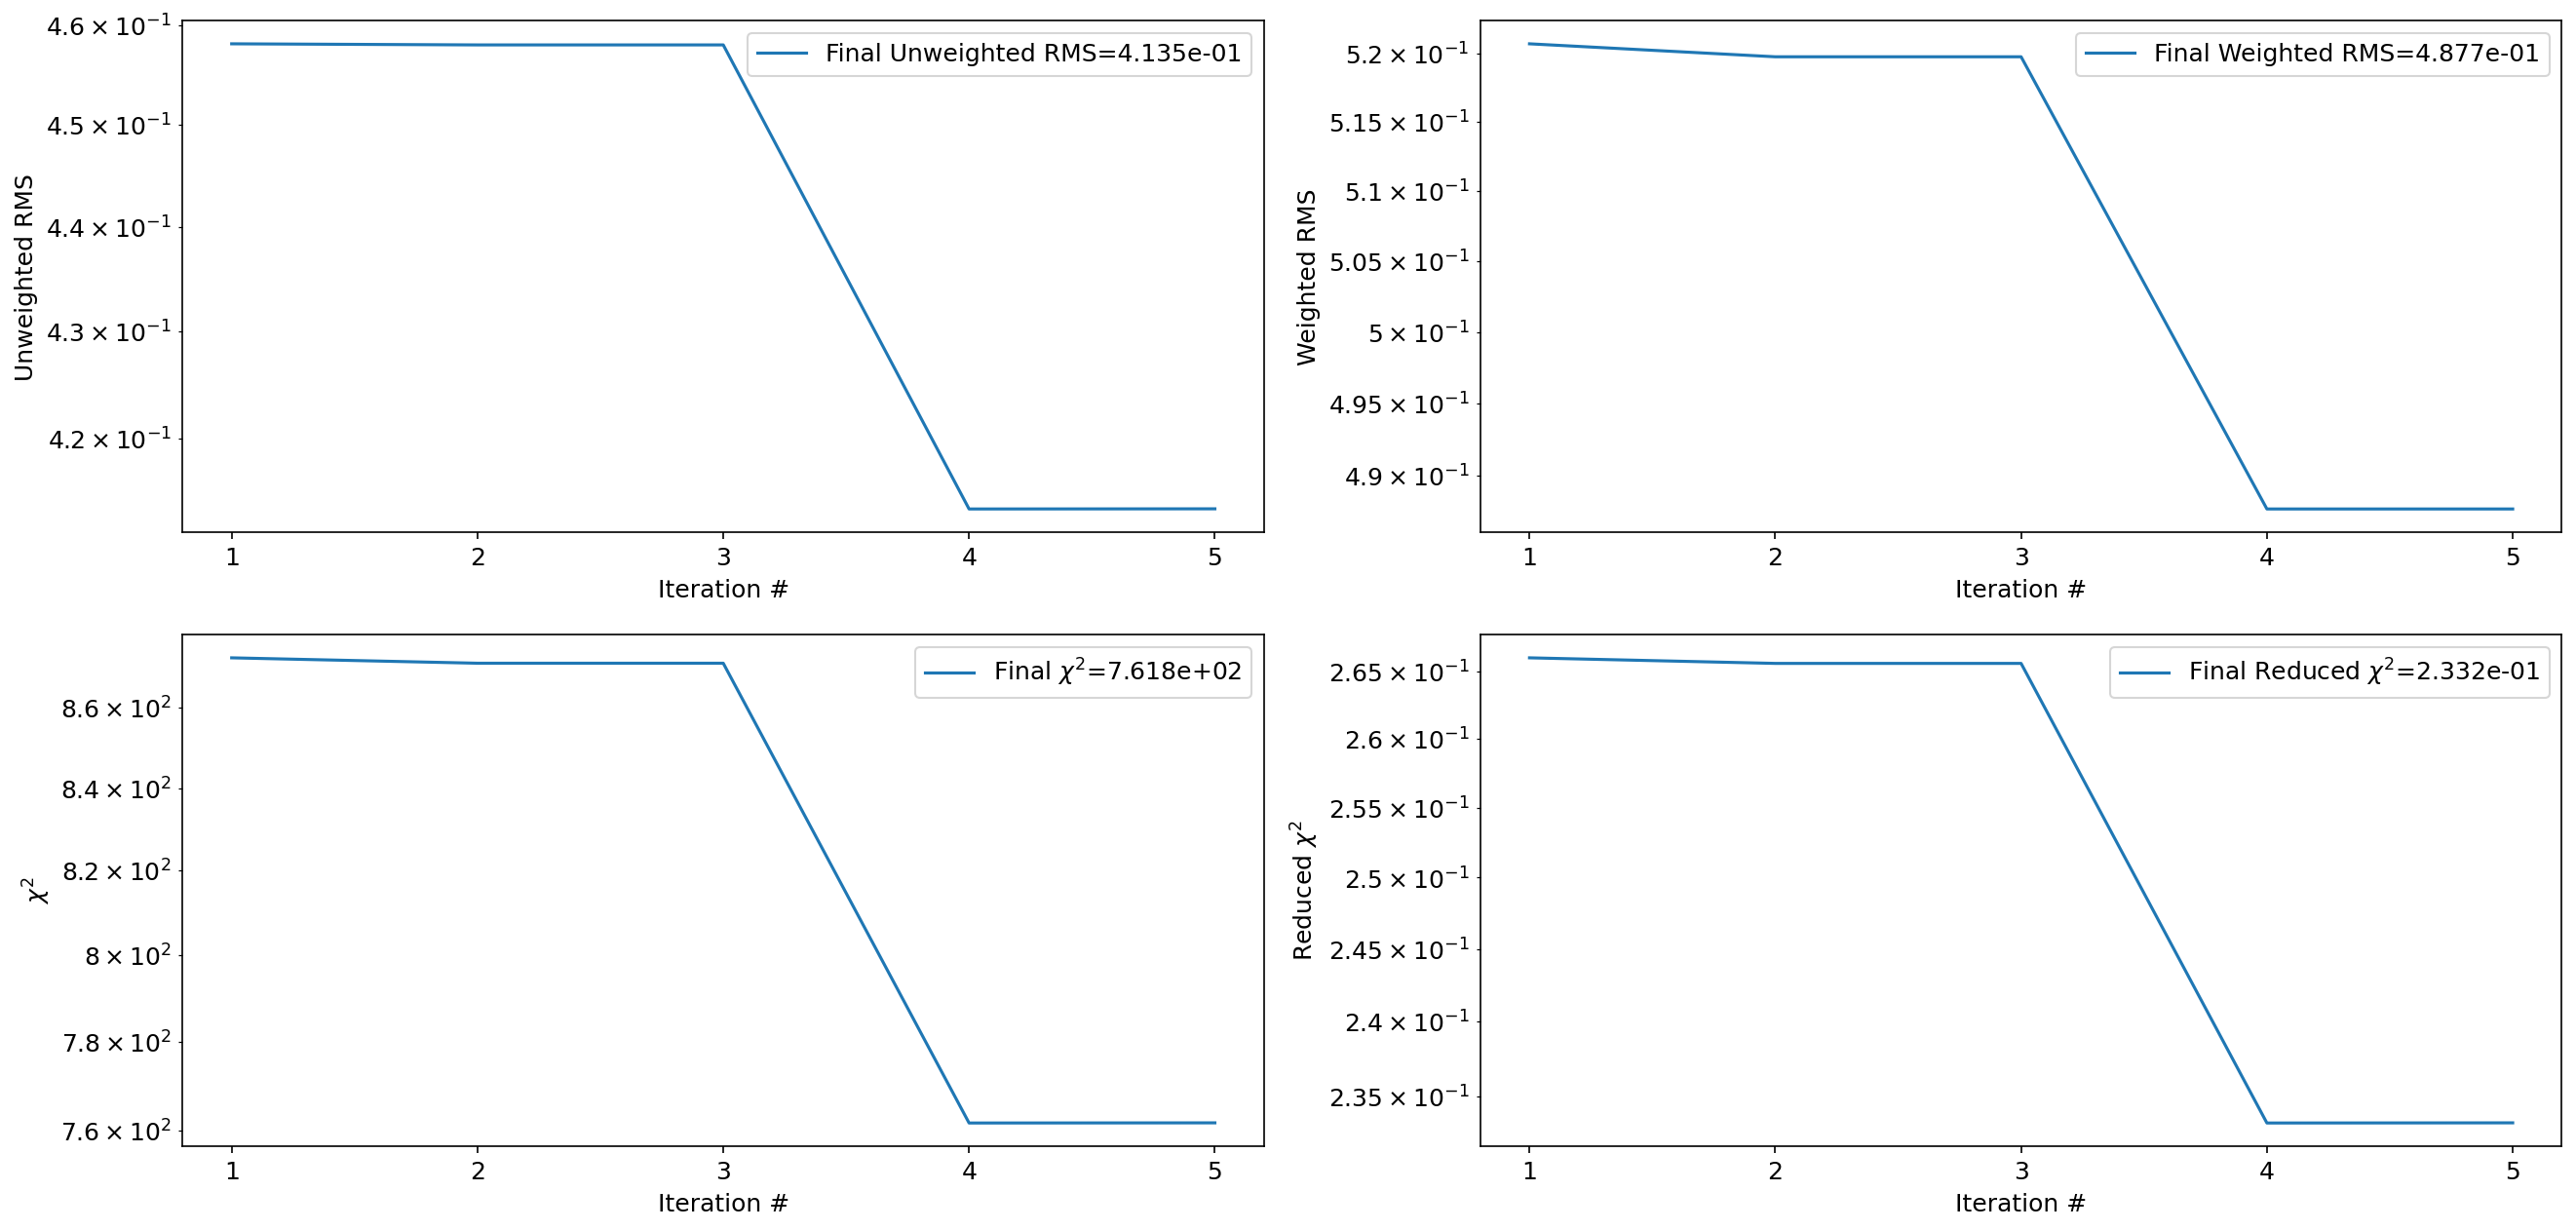

In [8]:
fit_sim.plot_summary(auto_close=True)

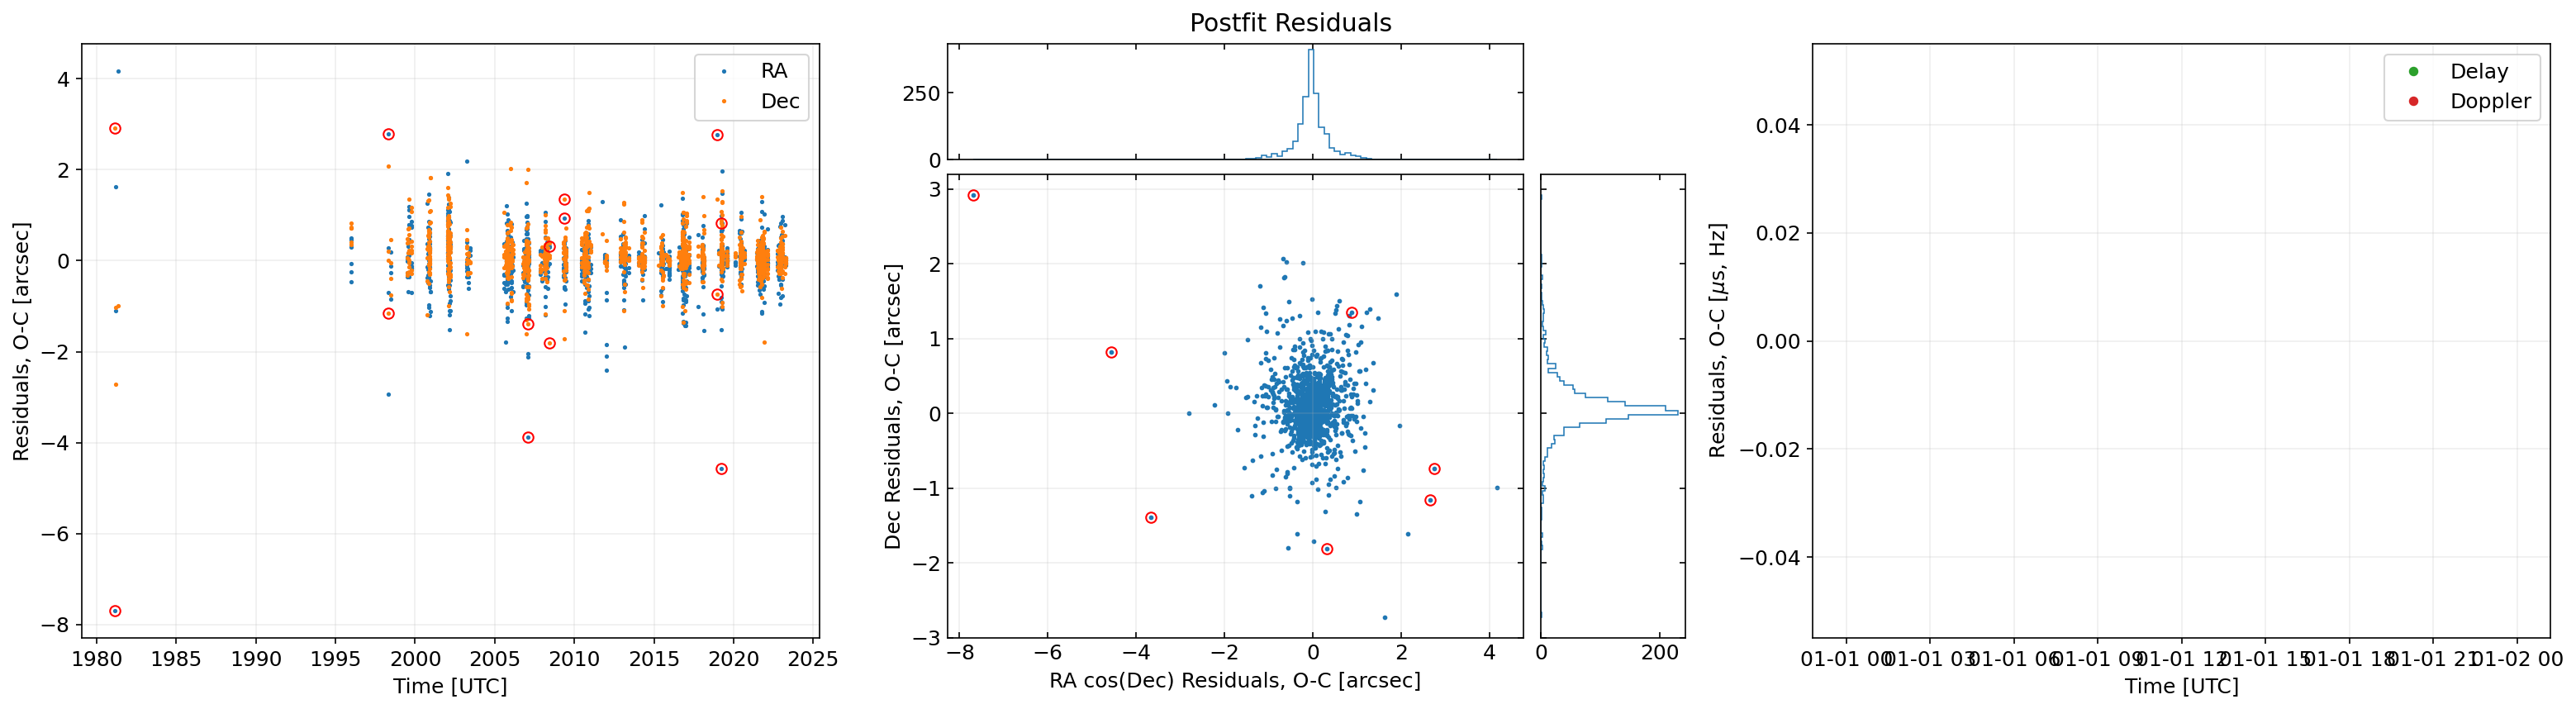

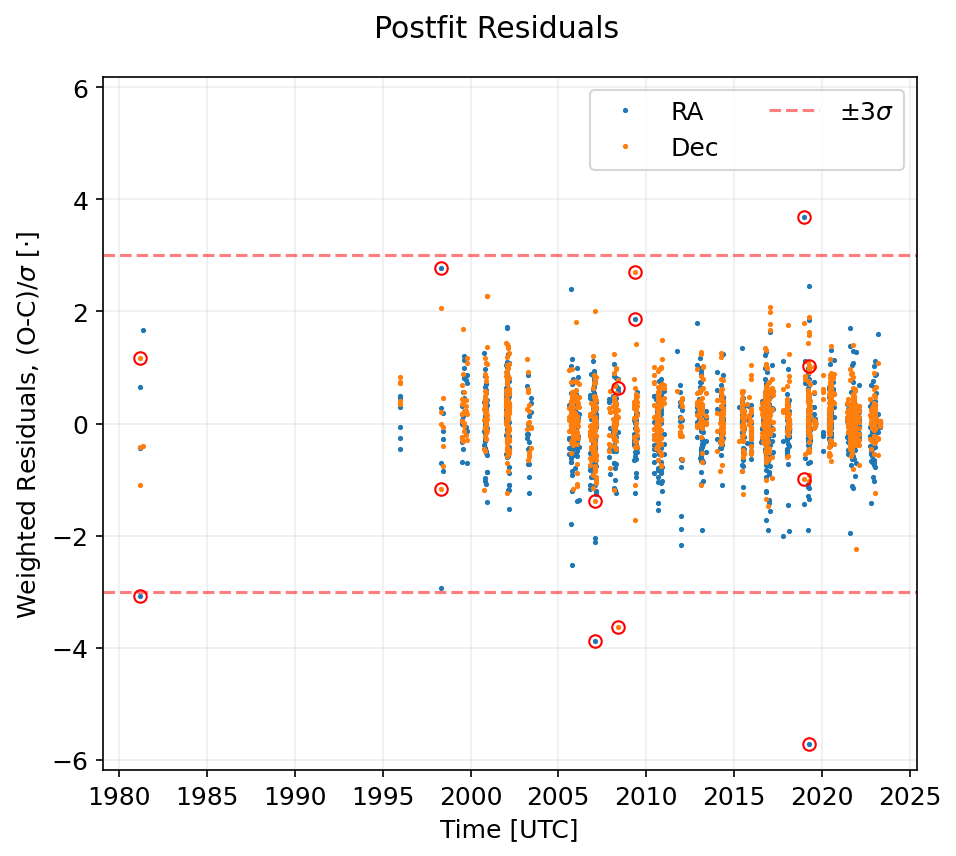

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 1.77
Mahalonobis distance between GRSS and JPL solution: 1.79
Bhattacharya distance between JPL and GRSS solution: 0.0004
Bhattacharya coefficient between JPL and GRSS solution: 0.9996


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90